<a href="https://colab.research.google.com/github/mdzikrim/DeepLearning/blob/main/LSTM_ReviewTokoBaju.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
df = pd.read_csv('/content/ReviewTokoBaju.csv')
df = df[['Review Text', 'Recommended IND']].dropna()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return word_tokenize(text)

df['tokens'] = df['Review Text'].apply(clean_text)

all_words = [word for tokens in df['tokens'] for word in tokens]
vocab = Counter(all_words)
vocab = {word: i+2 for i, (word, _) in enumerate(vocab.most_common(10000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

max_len = 100
def encode(tokens):
    ids = [vocab.get(word, vocab['<UNK>']) for word in tokens]
    if len(ids) < max_len:
        ids += [vocab['<PAD>']] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

df['encoded'] = df['tokens'].apply(encode)

# Split data
X = np.array(df['encoded'].tolist())
y = df['Recommended IND'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [4]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return self.sigmoid(out).squeeze()

vocab_size = len(vocab)
embed_dim = 128
hidden_dim = 128

model = LSTMClassifier(vocab_size, embed_dim, hidden_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


LSTMClassifier(
  (embedding): Embedding(10002, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [5]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_list, test_loss_list = [], []
train_acc_list, test_acc_list = [], []

for epoch in range(7):  # Tambah epoch kalau belum 80%
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs >= 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = correct / total
    train_loss_list.append(total_loss / len(train_loader))
    train_acc_list.append(train_acc)

    # Eval
    model.eval()
    correct, total, test_loss = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            preds = (outputs >= 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    test_acc = correct / total
    test_loss_list.append(test_loss / len(test_loader))
    test_acc_list.append(test_acc)

    print(f"Epoch {epoch+1} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1 - Train Acc: 0.8184, Test Acc: 0.8207
Epoch 2 - Train Acc: 0.8158, Test Acc: 0.8207
Epoch 3 - Train Acc: 0.8184, Test Acc: 0.8207
Epoch 4 - Train Acc: 0.8184, Test Acc: 0.8207
Epoch 5 - Train Acc: 0.8309, Test Acc: 0.8611
Epoch 6 - Train Acc: 0.8680, Test Acc: 0.8695
Epoch 7 - Train Acc: 0.8829, Test Acc: 0.8532


In [6]:
model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        probs = model(X_batch).cpu().numpy()
        preds = (probs >= 0.5).astype(int)

        y_probs.extend(probs)
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

# Hitung metrik evaluasi
akurasi   = accuracy_score(y_true, y_pred)
presisi   = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_probs)

# Tampilkan hasil
print(f"Akurasi  : {akurasi:.4f}")
print(f"Presisi  : {presisi:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc_score:.4f}")


Akurasi  : 0.8532
Presisi  : 0.9507
Recall   : 0.8660
F1-Score : 0.9064
AUC      : 0.9127


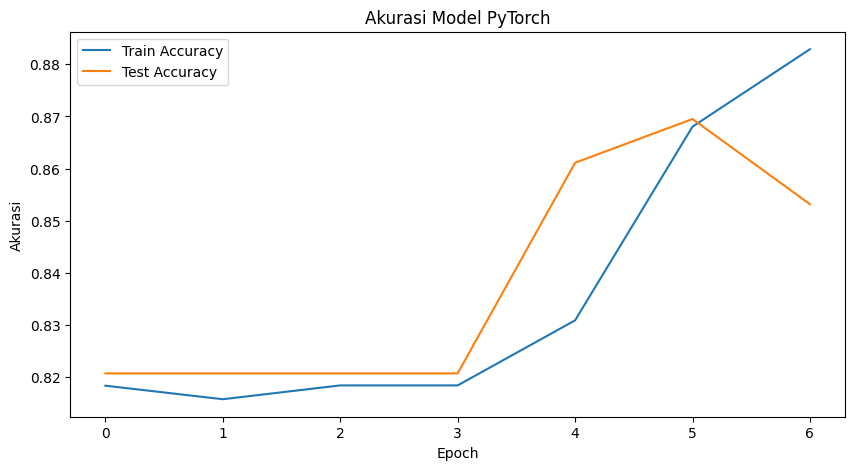

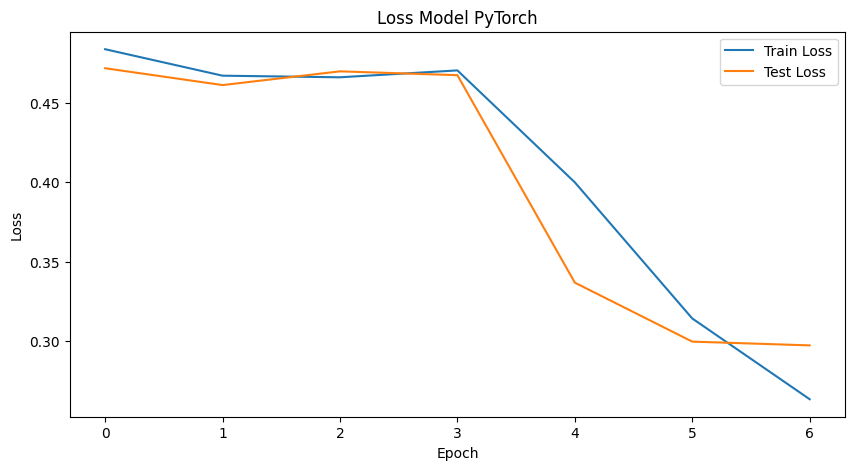

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.title('Akurasi Model PyTorch')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.title('Loss Model PyTorch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Tensorflow

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
# Load data
df = pd.read_csv("/content/ReviewTokoBaju.csv")
df = df[['Review Text', 'Recommended IND']].dropna()

# Clean dan tokenisasi
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

df['tokens'] = df['Review Text'].apply(clean_text)

# Vocab
all_words = [word for tokens in df['tokens'] for word in tokens]
vocab = Counter(all_words)
vocab = {word: i+2 for i, (word, _) in enumerate(vocab.most_common(10000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

# Encode dan pad
def encode_tokens(tokens, vocab, max_len=100):
    encoded = [vocab.get(word, vocab['<UNK>']) for word in tokens]
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded

df['encoded'] = df['tokens'].apply(lambda x: encode_tokens(x, vocab))

# Split data
X = np.array(df['encoded'].tolist())
y = df['Recommended IND'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
vocab_size = len(vocab)
embed_dim = 128
lstm_units = 128
max_len = 100

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len),
    LSTM(lstm_units, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=7,            # Bisa ditambah jika akurasi belum 80%
    batch_size=64
)


Epoch 1/7
283/283 ━━━━━━━━━━━━━━━━━━━━ 83s 277ms/step - accuracy: 0.8023 - loss: 0.4936 - val_accuracy: 0.8207 - val_loss: 0.4685
Epoch 2/7
283/283 ━━━━━━━━━━━━━━━━━━━━ 73s 245ms/step - accuracy: 0.8154 - loss: 0.4753 - val_accuracy: 0.8207 - val_loss: 0.4681
Epoch 3/7
283/283 ━━━━━━━━━━━━━━━━━━━━ 81s 244ms/step - accuracy: 0.8189 - loss: 0.4699 - val_accuracy: 0.8207 - val_loss: 0.4474
Epoch 4/7
283/283 ━━━━━━━━━━━━━━━━━━━━ 89s 267ms/step - accuracy: 0.8198 - loss: 0.4300 - val_accuracy: 0.8755 - val_loss: 0.3125
Epoch 5/7
283/283 ━━━━━━━━━━━━━━━━━━━━ 79s 257ms/step - accuracy: 0.8768 - loss: 0.2910 - val_accuracy: 0.8699 - val_loss: 0.2780
Epoch 6/7
283/283 ━━━━━━━━━━━━━━━━━━━━ 79s 245ms/step - accuracy: 0.9179 - loss: 0.2067 - val_accuracy: 0.8867 - val_loss: 0.2836
Epoch 7/7
283/283 ━━━━━━━━━━━━━━━━━━━━ 87s 262ms/step - accuracy: 0.9376 - loss: 0.1672 - val_accuracy: 0.8870 - val_loss: 0.2795


In [12]:
# Prediksi
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)

# Evaluasi
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_probs)
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)

print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step
Akurasi  : 0.8870
Presisi  : 0.9190
Recall   : 0.9457
F1-Score : 0.9321
AUC      : 0.9244


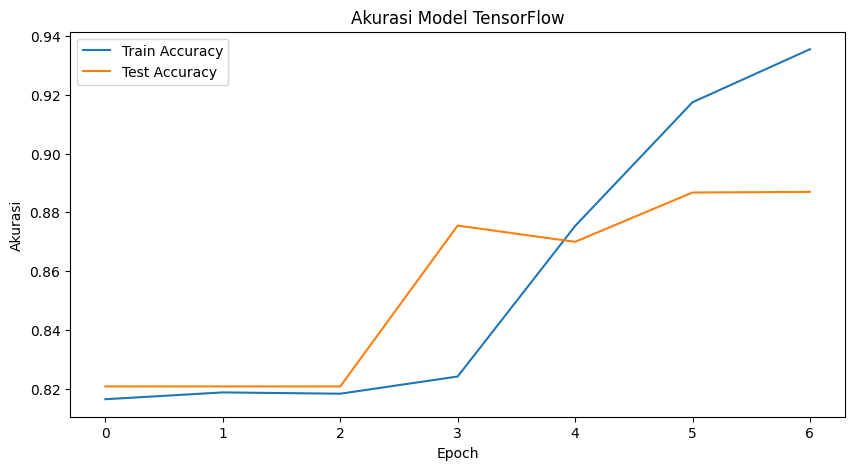

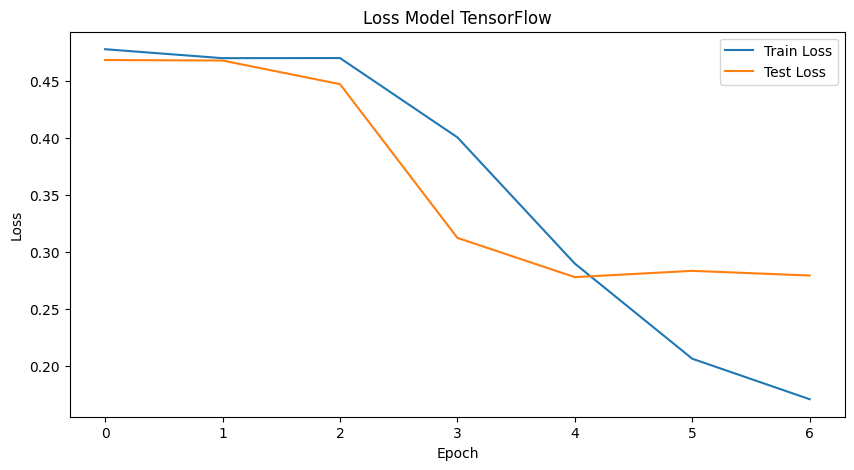

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Akurasi Model TensorFlow')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss Model TensorFlow')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()